In [105]:
import numpy as np
import pandas as pd
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

# Permet d'afficher toutes les colonnes
pd.set_option('display.max_columns', None)

In [106]:
water_important_cols = [
    'row_index',
    'meteo_rain_height',
    'meteo_evapotranspiration_grid',
    'meteo_sunshine_%',
    'meteo_temperature_avg',
    'meteo_temperature_min',
    'meteo_temperature_max',
    'meteo_amplitude_tn_tx',
    'meteo_humidity_avg',
    'meteo_humidity_min',
    'meteo_pressure_avg',
    'meteo_cloudiness',
    'meteo_frost_duration',
    'meteo_wetting_duration',
    'meteo_humidity_duration_below_40%',
    'meteo_humidity_duration_above_80%',
    'meteo_radiation_direct',
    'meteo_radiation',
    'meteo_radiation_IR',
    'meteo_if_snow',
    'meteo_snow_height',
    'meteo_snow_thickness_6h',
    'meteo_snow_thickness_max'
]

In [107]:
data_meteo_part = pd.read_csv("X_train_Hi5.csv", usecols=water_important_cols)

In [108]:
data_meteo_part['meteo_amplitude_tn_tx'] = data_meteo_part['meteo_amplitude_tn_tx'].fillna(data_meteo_part['meteo_temperature_max'] - data_meteo_part['meteo_temperature_min'])
data_meteo_part['meteo_temperature_min'] = data_meteo_part['meteo_temperature_min'].fillna(data_meteo_part['meteo_temperature_max'] - data_meteo_part['meteo_amplitude_tn_tx'])
data_meteo_part['meteo_temperature_max'] = data_meteo_part['meteo_temperature_max'].fillna(data_meteo_part['meteo_temperature_min'] + data_meteo_part['meteo_amplitude_tn_tx'])

<Axes: >

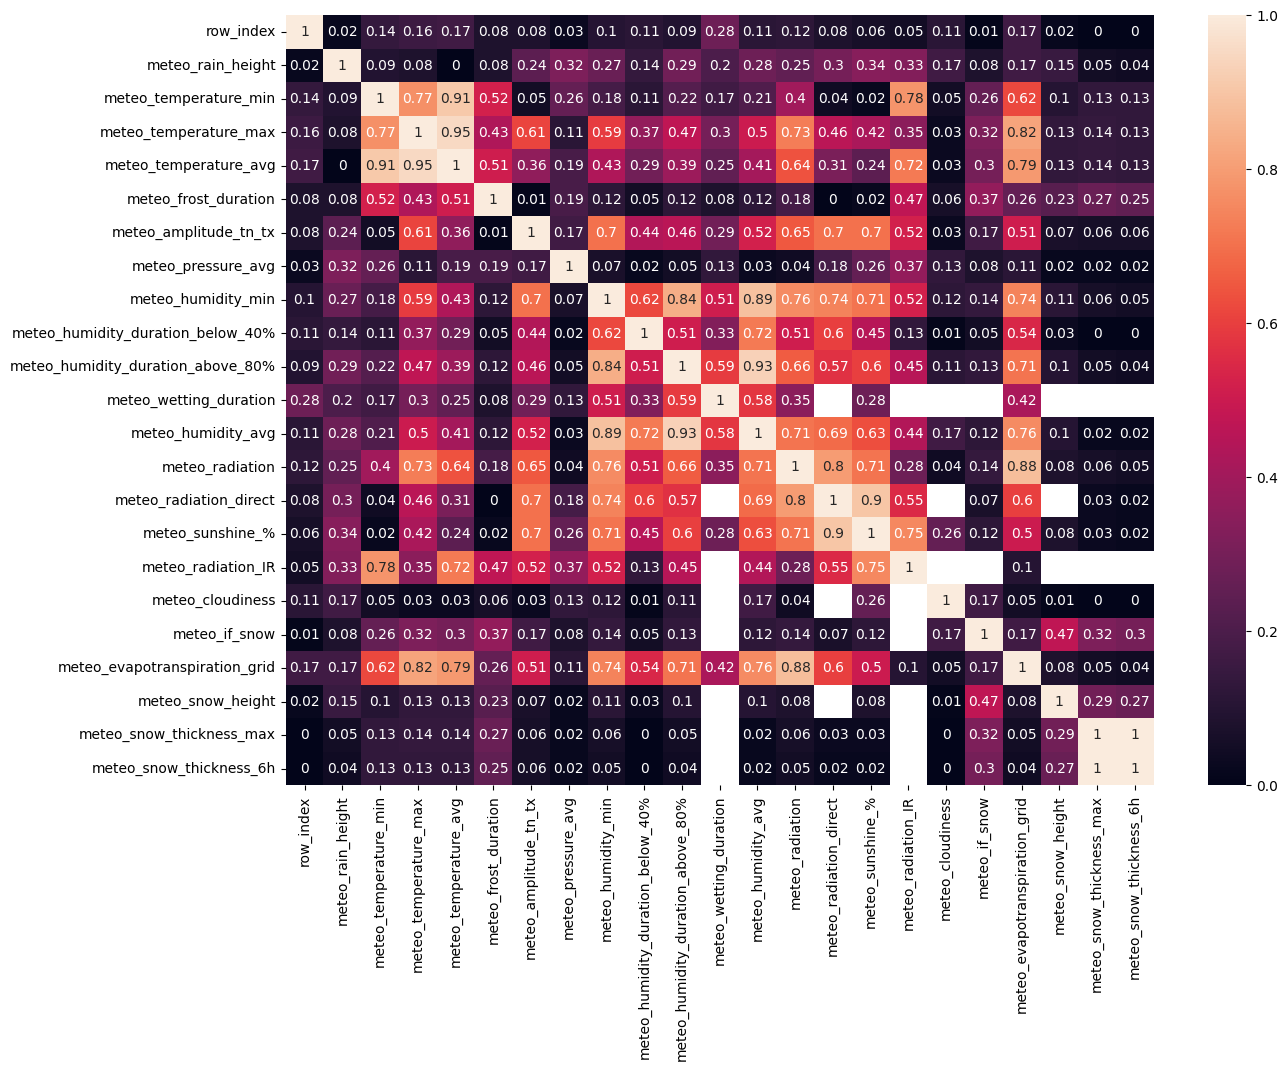

In [109]:
plt.figure(figsize=(14,10))
sns.heatmap(data_meteo_part.corr().abs().round(2),annot=True)

In [133]:
(data_meteo_part.isna().sum()/len(data_meteo_part)).round(3)

row_index                            0.000
meteo_rain_height                    0.000
meteo_temperature_min                0.000
meteo_temperature_max                0.000
meteo_temperature_avg                0.000
meteo_frost_duration                 0.000
meteo_pressure_avg                   0.000
meteo_humidity_min                   0.000
meteo_humidity_duration_below_40%    0.000
meteo_humidity_duration_above_80%    0.000
meteo_humidity_avg                   0.000
meteo_radiation                      0.000
meteo_radiation_direct               0.000
meteo_sunshine_%                     0.000
meteo_if_snow                        0.000
meteo_evapotranspiration_grid        0.000
meteo_snow_height                    0.004
meteo_snow_thickness_max             0.002
temp_range_min                       0.000
temp_range_max                       0.000
evapotranspiration_range             0.000
frost_range                          0.000
radiation_range                      0.000
radiation_d

In [111]:
data_meteo_part.drop(columns=['meteo_radiation_IR','meteo_cloudiness','meteo_wetting_duration','meteo_amplitude_tn_tx','meteo_snow_thickness_6h'], inplace = True)
data_meteo_part = data_meteo_part.dropna(subset=['meteo_rain_height','meteo_temperature_min','meteo_temperature_max','meteo_frost_duration','meteo_evapotranspiration_grid'])

In [112]:
# Définir des tranches pour meteo_temperature_max et meteo_temperature_min
bins_min = [-30, 5, 10, 15, 20, 40]  # Tranches pour la température minimale
bins_max = [-10, 20, 30, 40, 60]      # Tranches pour la température maximale

labels_min = ['-30-5', '5-10', '10-15', '15-20', '20-40']
labels_max = ['-10-20', '20-30', '30-40', '40-60']

# Ajouter des colonnes de tranches
data_meteo_part['temp_range_min'] = pd.cut(data_meteo_part['meteo_temperature_min'], bins=bins_min, labels=labels_min, right=False)
data_meteo_part['temp_range_max'] = pd.cut(data_meteo_part['meteo_temperature_max'], bins=bins_max, labels=labels_max, right=False)

# Regrouper par les tranches de température minimale et maximale et calculer les moyennes de meteo_temperature_avg
group_cols_temp = ['temp_range_min', 'temp_range_max']
temperature_avg = data_meteo_part.groupby(group_cols_temp)['meteo_temperature_avg'].mean()

# Remplir les NaN de meteo_temperature_avg avec les moyennes calculées pour les tranches correspondantes
data_meteo_part['meteo_temperature_avg'] = data_meteo_part.apply(
    lambda row: temperature_avg.get(
        (row['temp_range_min'], row['temp_range_max']),
        row['meteo_temperature_avg']
    ) if pd.isna(row['meteo_temperature_avg']) else row['meteo_temperature_avg'],
    axis=1
)

# Vérification des NaN restants
print("Nombre de NaN après remplissage dans 'meteo_temperature_avg':", data_meteo_part['meteo_temperature_avg'].isna().sum())


Nombre de NaN après remplissage dans 'meteo_temperature_avg': 0


In [113]:
# Définir des tranches pour meteo_evapotranspiration_grid
bins_evaporation = [0, 2, 4, 6, 8, 10]  # Tranches pour meteo_evapotranspiration_grid

labels_evaporation = ['0-2', '2-4', '4-6', '6-8', '8-10']

# Ajouter des colonnes de tranches
data_meteo_part['evapotranspiration_range'] = pd.cut(data_meteo_part['meteo_evapotranspiration_grid'], bins=bins_evaporation, labels=labels_evaporation, right=False)

# Regrouper par les tranches de evapotranspiration_range et temp_range_max et calculer les moyennes de meteo_radiation
group_cols_radiation = ['evapotranspiration_range', 'temp_range_max']
radiation_avg = data_meteo_part.groupby(group_cols_radiation)['meteo_radiation'].mean()

# Remplir les NaN de meteo_radiation avec les moyennes calculées pour les tranches correspondantes
data_meteo_part['meteo_radiation'] = data_meteo_part.apply(
    lambda row: radiation_avg.get(
        (row['evapotranspiration_range'], row['temp_range_max']),
        row['meteo_radiation']
    ) if pd.isna(row['meteo_radiation']) else row['meteo_radiation'],
    axis=1
)

# Vérification des NaN restants
print("Nombre de NaN après remplissage dans 'meteo_radiation':", data_meteo_part['meteo_radiation'].isna().sum())


Nombre de NaN après remplissage dans 'meteo_radiation': 8


In [114]:
data_meteo_part['meteo_if_snow'].describe()

count    378454.000000
mean          0.027020
std           0.162143
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: meteo_if_snow, dtype: float64

In [115]:
# Définir des tranches pour meteo_frost_duration et meteo_temperature_max
bins_frost = [0, 100, 1000, 1500]  # Tranches pour meteo_frost_duration
labels_frost = ['0-100', '100-1000', '1000-1500']

# Ajouter des colonnes de tranches
data_meteo_part['frost_range'] = pd.cut(data_meteo_part['meteo_frost_duration'], bins=bins_frost, labels=labels_frost, right=False)

# Calculer la proportion de 1 dans chaque groupe
group_cols_snow = ['frost_range', 'temp_range_max']
snow_proportion = data_meteo_part.groupby(group_cols_snow)['meteo_if_snow'].mean()

# Définir un seuil pour classer en 0 ou 1
threshold = 0.5  # Si la proportion est > 0.5, on assigne 1, sinon 0
snow_binary = snow_proportion.apply(lambda x: 1 if x > threshold else 0)

# Remplir les NaN dans meteo_if_snow
data_meteo_part['meteo_if_snow'] = data_meteo_part.apply(
    lambda row: snow_binary.get(
        (row['frost_range'], row['temp_range_max']),
        row['meteo_if_snow']
    ) if pd.isna(row['meteo_if_snow']) else row['meteo_if_snow'],
    axis=1
)

# Vérification des NaN restants
print("Nombre de NaN après remplissage dans 'meteo_if_snow':", data_meteo_part['meteo_if_snow'].isna().sum())


Nombre de NaN après remplissage dans 'meteo_if_snow': 0


In [120]:
# Mettre à zéro les colonnes meteo_snow_thickness_max et meteo_snow_height quand meteo_if_snow est nul
data_meteo_part.loc[data_meteo_part['meteo_if_snow'] == 0, ['meteo_snow_thickness_max', 'meteo_snow_height']] = 0


In [124]:
# Définir des tranches pour meteo_radiation
bins_radiation = [0, 500, 1000, 1500, 3500]  # Tranches pour la radiation infrarouge
labels_radiation = ['0-500', '500-1000', '1000-1500', '1500-3500']

# Ajouter une colonne de tranches pour meteo_radiation
data_meteo_part['radiation_range'] = pd.cut(data_meteo_part['meteo_radiation'], bins=bins_radiation, labels=labels_radiation, right=False)

# Regrouper par les tranches de radiation infrarouge et calculer les moyennes de meteo_radiation_direct
group_cols_radiation = ['radiation_range']
radiation_avg = data_meteo_part.groupby(group_cols_radiation)['meteo_radiation_direct'].mean()

# Remplir les NaN de meteo_radiation_direct avec les moyennes calculées pour les tranches correspondantes
data_meteo_part['meteo_radiation_direct'] = data_meteo_part.apply(
    lambda row: radiation_avg.get(row['radiation_range'], row['meteo_radiation_direct'])
    if pd.isna(row['meteo_radiation_direct']) else row['meteo_radiation_direct'],
    axis=1
)

# Vérification des NaN restants
print("Nombre de NaN après remplissage dans 'meteo_radiation_direct':", data_meteo_part['meteo_radiation_direct'].isna().sum())


Nombre de NaN après remplissage dans 'meteo_radiation_direct': 8


In [129]:
data_meteo_part['meteo_rain_height'].describe()

count    2.348996e+06
mean     2.063350e+00
std      5.141143e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e-01
75%      1.600000e+00
max      2.138000e+02
Name: meteo_rain_height, dtype: float64

In [127]:
# Définir des tranches pour meteo_radiation_direct
bins_radiation_direct = [0, 700, 1000, 2000, 5000]  # Tranches pour la radiation directe
labels_radiation_direct = ['0-700', '700-1000', '1000-2000', '2000-5000']

# Ajouter une colonne de tranches pour meteo_radiation_direct
data_meteo_part['radiation_direct_range'] = pd.cut(data_meteo_part['meteo_radiation_direct'], bins=bins_radiation_direct, labels=labels_radiation_direct, right=False)

# Regrouper par les tranches de radiation directe et calculer les moyennes de meteo_sunshine_%
group_cols_sunshine = ['radiation_direct_range']
sunshine_avg = data_meteo_part.groupby(group_cols_sunshine)['meteo_sunshine_%'].mean()

# Remplir les NaN de meteo_sunshine_% avec les moyennes calculées pour les tranches correspondantes
data_meteo_part['meteo_sunshine_%'] = data_meteo_part.apply(
    lambda row: sunshine_avg.get(row['radiation_direct_range'], row['meteo_sunshine_%'])
    if pd.isna(row['meteo_sunshine_%']) else row['meteo_sunshine_%'],
    axis=1
)

# Vérification des NaN restants
print("Nombre de NaN après remplissage dans 'meteo_sunshine_%':", data_meteo_part['meteo_sunshine_%'].isna().sum())


Nombre de NaN après remplissage dans 'meteo_sunshine_%': 8


In [130]:
# Définir des tranches pour meteo_rain_height
bins_rain_height = [0, 0.2, 1, 250]  # Tranches pour la hauteur de pluie
labels_rain_height = ['0-0.2', '0.2-1', '1-250']

# Ajouter une colonne de tranches pour meteo_rain_height
data_meteo_part['rain_height_range'] = pd.cut(data_meteo_part['meteo_rain_height'], bins=bins_rain_height, labels=labels_rain_height, right=False)

# Regrouper par les tranches de rain_height et calculer les moyennes de meteo_pressure_avg
group_cols_pressure = ['rain_height_range']
pressure_avg = data_meteo_part.groupby(group_cols_pressure)['meteo_pressure_avg'].mean()

# Remplir les NaN de meteo_pressure_avg avec les moyennes calculées pour les tranches correspondantes
data_meteo_part['meteo_pressure_avg'] = data_meteo_part.apply(
    lambda row: pressure_avg.get(row['rain_height_range'], row['meteo_pressure_avg'])
    if pd.isna(row['meteo_pressure_avg']) else row['meteo_pressure_avg'],
    axis=1
)

# Vérification des NaN restants
print("Nombre de NaN après remplissage dans 'meteo_pressure_avg':", data_meteo_part['meteo_pressure_avg'].isna().sum())


Nombre de NaN après remplissage dans 'meteo_pressure_avg': 0


In [132]:
# Regrouper par les tranches de radiation et calculer les moyennes
group_cols_humidity = ['radiation_range']

# Calcul des moyennes pour chaque variable d'humidité
humidity_min_avg = data_meteo_part.groupby(group_cols_humidity)['meteo_humidity_min'].mean()
humidity_duration_below_40_avg = data_meteo_part.groupby(group_cols_humidity)['meteo_humidity_duration_below_40%'].mean()
humidity_duration_above_80_avg = data_meteo_part.groupby(group_cols_humidity)['meteo_humidity_duration_above_80%'].mean()
humidity_avg_avg = data_meteo_part.groupby(group_cols_humidity)['meteo_humidity_avg'].mean()

# Remplir les NaN pour meteo_humidity_min
data_meteo_part['meteo_humidity_min'] = data_meteo_part.apply(
    lambda row: humidity_min_avg.get(row['radiation_range'], row['meteo_humidity_min'])
    if pd.isna(row['meteo_humidity_min']) else row['meteo_humidity_min'],
    axis=1
)

# Remplir les NaN pour meteo_humidity_duration_below_40%
data_meteo_part['meteo_humidity_duration_below_40%'] = data_meteo_part.apply(
    lambda row: humidity_duration_below_40_avg.get(row['radiation_range'], row['meteo_humidity_duration_below_40%'])
    if pd.isna(row['meteo_humidity_duration_below_40%']) else row['meteo_humidity_duration_below_40%'],
    axis=1
)

# Remplir les NaN pour meteo_humidity_duration_above_80%
data_meteo_part['meteo_humidity_duration_above_80%'] = data_meteo_part.apply(
    lambda row: humidity_duration_above_80_avg.get(row['radiation_range'], row['meteo_humidity_duration_above_80%'])
    if pd.isna(row['meteo_humidity_duration_above_80%']) else row['meteo_humidity_duration_above_80%'],
    axis=1
)

# Remplir les NaN pour meteo_humidity_avg
data_meteo_part['meteo_humidity_avg'] = data_meteo_part.apply(
    lambda row: humidity_avg_avg.get(row['radiation_range'], row['meteo_humidity_avg'])
    if pd.isna(row['meteo_humidity_avg']) else row['meteo_humidity_avg'],
    axis=1
)

# Vérification des NaN restants
print("Nombre de NaN après remplissage dans 'meteo_humidity_min':", data_meteo_part['meteo_humidity_min'].isna().sum())
print("Nombre de NaN après remplissage dans 'meteo_humidity_duration_below_40%':", data_meteo_part['meteo_humidity_duration_below_40%'].isna().sum())
print("Nombre de NaN après remplissage dans 'meteo_humidity_duration_above_80%':", data_meteo_part['meteo_humidity_duration_above_80%'].isna().sum())
print("Nombre de NaN après remplissage dans 'meteo_humidity_avg':", data_meteo_part['meteo_humidity_avg'].isna().sum())


Nombre de NaN après remplissage dans 'meteo_humidity_min': 5
Nombre de NaN après remplissage dans 'meteo_humidity_duration_below_40%': 5
Nombre de NaN après remplissage dans 'meteo_humidity_duration_above_80%': 5
Nombre de NaN après remplissage dans 'meteo_humidity_avg': 5


In [134]:
data_meteo_part.dropna(inplace=True)

In [135]:
data_meteo_part.isna().sum()

row_index                            0
meteo_rain_height                    0
meteo_temperature_min                0
meteo_temperature_max                0
meteo_temperature_avg                0
meteo_frost_duration                 0
meteo_pressure_avg                   0
meteo_humidity_min                   0
meteo_humidity_duration_below_40%    0
meteo_humidity_duration_above_80%    0
meteo_humidity_avg                   0
meteo_radiation                      0
meteo_radiation_direct               0
meteo_sunshine_%                     0
meteo_if_snow                        0
meteo_evapotranspiration_grid        0
meteo_snow_height                    0
meteo_snow_thickness_max             0
temp_range_min                       0
temp_range_max                       0
evapotranspiration_range             0
frost_range                          0
radiation_range                      0
radiation_direct_range               0
rain_height_range                    0
dtype: int64

In [136]:
len(data_meteo_part)

2340084